In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

# Import data

In [15]:
rows=[]
with open('book1.csv','r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
       rows.append([float(x) for x in row]) 
# first row is bad. remove.
#rows = rows[1:]
wn = range(-10600,-3999,2)
labels = ['64cm-1','32cm-1','16cm-1','8cm-1','4cm-1']


# Polystyrene measured using optical resolution 64, 32, 16, 8, 4 cm-1 

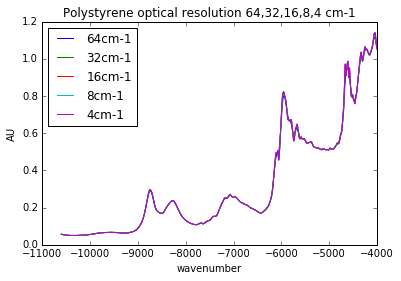

In [22]:
%matplotlib inline
for rowIdx in range(len(rows)):
    plt.plot(wn,rows[rowIdx],label=labels[rowIdx])
plt.title('Polystyrene optical resolution 64,32,16,8,4 cm-1')
plt.ylabel('AU')
plt.xlabel("wavenumber")
plt.legend(loc=2)
plt.show()

# Close up 6100-5600 cm-1

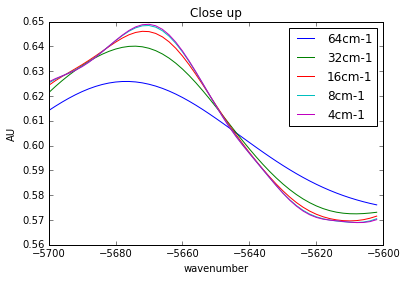

Resolution 8 and 4 are very close. J-stop limitations??


In [50]:
for rowIdx in range(len(rows)):
    plt.plot(wn[2450:2500],rows[rowIdx][2450:2500],label=labels[rowIdx])
plt.title('Close up')
plt.ylabel('AU')
plt.xlabel("wavenumber")
plt.legend()
plt.show()

print('Resolution 8 and 4 are very close. J-stop limitations??')

# Define Lorentzian filter

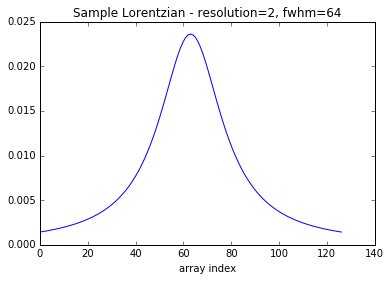

In [5]:
def makeLorentzianFilter(resolution,fwhm):
    f = []
    for idx in  range( (int)(2*fwhm/resolution)):
        x= 2*resolution *idx / fwhm
        f.append(1.0/(1.0+(x*x)))
    result =  list(reversed(f))[:-1]
    result.extend(f)
    result = np.divide(result,np.sum(result))
    return result
plt.plot(makeLorentzianFilter(2,64))
plt.title('Sample Lorentzian - resolution=2, fwhm=64')
plt.ylabel('')
plt.xlabel("array index")
plt.show()

# Define Box filter

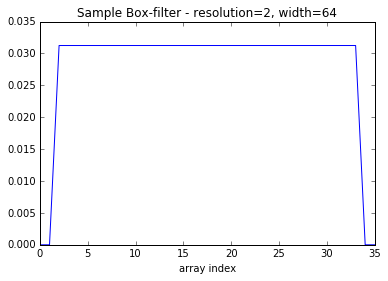

In [6]:
def makeBoxFilter(resolution,width):
    f = []
    f.append(0)
    f.append(0)
    f.extend( [1.0 / (width/resolution) for x in range( (int)(width/resolution))] )
    f.append(0)
    f.append(0)
    return f

plt.plot(makeBoxFilter(2,64))
plt.title('Sample Box-filter - resolution=2, width=64')
plt.ylabel('')
plt.xlabel("array index")
plt.show()

# Define Triangle filter

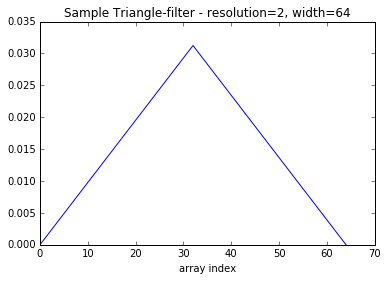

In [7]:
%matplotlib inline
def makeTriangleFilter(resolution,width):
    steps = width/resolution
    f = [(1.0-x*(resolution)/width) for x in range((int)(steps)+1)]
    result =  list(reversed(f))[:-1]
    result.extend(f)
    return np.divide(result,np.sum(result))

plt.plot(makeTriangleFilter(2.0,64.0))
plt.title('Sample Triangle-filter - resolution=2, width=64')
plt.ylabel('')
plt.xlabel("array index")
plt.show()    

# Define Gaussian filter

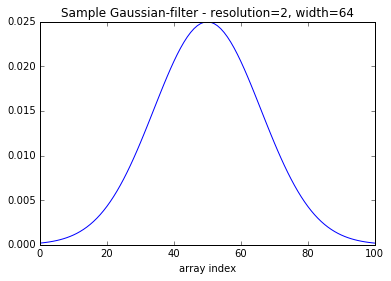

In [8]:
def makeGaussianFilter(resolution,width):
    gaussianFilter = signal.gaussian(101,std=0.5*width/resolution)
    return np.divide(gaussianFilter,np.sum(gaussianFilter))

plt.plot(makeGaussianFilter(2.0,64.0))
plt.title('Sample Gaussian-filter - resolution=2, width=64')
plt.ylabel('')
plt.xlabel("array index")
plt.show() 

# Search best filter widths

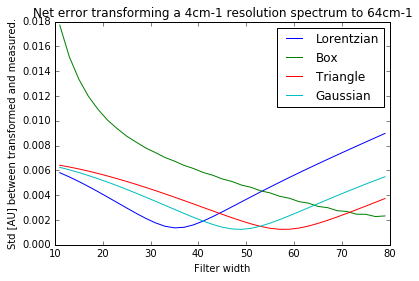

Best Lorentzian width:35. Std:0.0013662685908
Best Box width:77. Std:0.00227841914976
Best Triangle width:57. Std:0.00124841782059
Best Gaussian width:49. Std:0.00124574924406


In [51]:
spectrum_res_4 = rows[4]
spectrum_res_64 = rows[0]
std_lorentz = []
std_box = []
std_triangle = []
std_gaussian = []

test_range = range(11,80,2)

for filter_width in test_range:

    # filter using Lorentz shape at current filter width
    lorentzFilter = makeLorentzianFilter(2,filter_width)
    lorentz_filtered = np.convolve(spectrum_res_4,lorentzFilter,'same')
    diff_lorentz = np.subtract(lorentz_filtered,spectrum_res_64)
    std_lorentz.append(np.std(diff_lorentz[400:-400]))

    # filter using Box shape at current filter width
    boxFilter = makeBoxFilter(2,filter_width)
    box_filtered = np.convolve(spectrum_res_4,boxFilter,'same')
    diff_box = np.subtract(box_filtered,spectrum_res_64)
    std_box.append(np.std(diff_box[400:-400]))

    # filter using Triangle shape at current filter width
    triangleFilter = makeTriangleFilter(2,filter_width)
    triangle_filtered = np.convolve(spectrum_res_4,triangleFilter,'same')
    diff_triangle = np.subtract(triangle_filtered,spectrum_res_64)
    std_triangle.append(np.std(diff_triangle[400:-400]))
    
    # filter using Gaussian shape
    gaussianFilter = makeGaussianFilter(2,filter_width)
    gaussian_filtered = np.convolve(spectrum_res_4,gaussianFilter,'same')
    diff_gaussian = np.subtract(gaussian_filtered,spectrum_res_64)
    std_gaussian.append(np.std(diff_gaussian[400:-400]))
    
plt.plot(test_range,std_lorentz, label='Lorentzian')
plt.plot(test_range,std_box, label='Box')
plt.plot(test_range,std_triangle, label='Triangle')
plt.plot(test_range,std_gaussian, label='Gaussian')
plt.legend()
plt.title('Net error transforming a 4cm-1 resolution spectrum to 64cm-1')
plt.ylabel('Std [AU] between transformed and measured.')
plt.xlabel("Filter width")

plt.show()

# Find best
bestLorentzianIdx = np.argmin(std_lorentz)
bestBoxIdx = np.argmin(std_box)
bestTriangleIdx = np.argmin(std_triangle)
bestGaussianIdx = np.argmin(std_gaussian)

# Report best
print ("Best Lorentzian width:" + str(test_range[bestLorentzianIdx]) + ". Std:" + str(std_lorentz[bestLorentzianIdx]))
print ("Best Box width:" + str(test_range[bestBoxIdx]) + ". Std:" + str(std_box[bestBoxIdx]))
print ("Best Triangle width:" + str(test_range[bestTriangleIdx]) + ". Std:" + str(std_triangle[bestTriangleIdx]))
print ("Best Gaussian width:" + str(test_range[bestGaussianIdx]) + ". Std:" + str(std_gaussian[bestGaussianIdx]))

# Original difference between 4cm-1 and 64cm-1

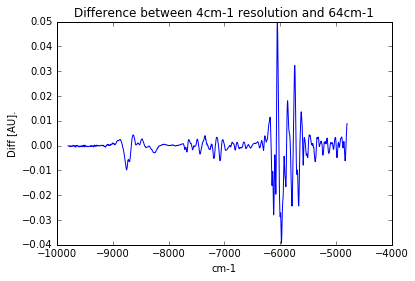

In [59]:
errOriginal = np.subtract(spectrum_res_64,spectrum_res_4)
plt.plot(wn[400:-400],errOriginal[400:-400])
plt.title('Difference between 4cm-1 resolution and 64cm-1')
plt.ylabel('Diff [AU].')
plt.xlabel("cm-1")
plt.show()

# Net error for best Lorentzian filter

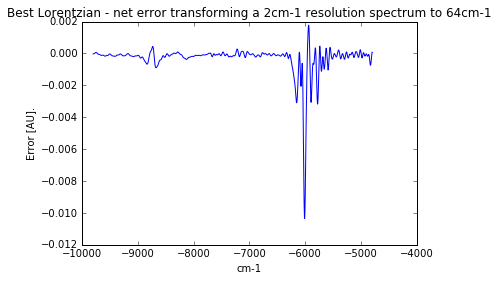

In [43]:
errBestLorentzian = np.subtract(spectrum_res_64,np.convolve(spectrum_res_4,makeLorentzianFilter(2,test_range[bestLorentzianIdx]),'same'))
plt.plot(wn[400:-400],errBestLorentzian[400:-400])
plt.title('Best Lorentzian - net error transforming a 4cm-1 resolution spectrum to 64cm-1')
plt.ylabel('Error [AU].')
plt.xlabel("cm-1")
plt.show()

# Net error for best Box filter

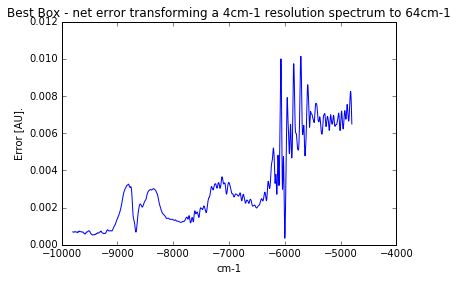

In [55]:
errBestBox = np.subtract(spectrum_res_64,np.convolve(spectrum_res_4,makeBoxFilter(2,test_range[bestBoxIdx]),'same'))
plt.plot(wn[400:-400],errBestBox[400:-400])
plt.title('Best Box - net error transforming a 4cm-1 resolution spectrum to 64cm-1')
plt.ylabel('Error [AU].')
plt.xlabel("cm-1")
plt.show()

# Net error for best Triangle filter

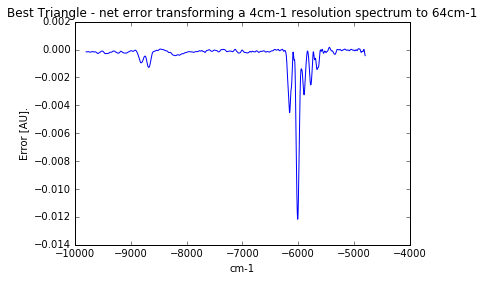

In [54]:
errBestTriangle = np.subtract(spectrum_res_64,np.convolve(spectrum_res_4,makeTriangleFilter(2,test_range[bestTriangleIdx]),'same'))
plt.plot(wn[400:-400],errBestTriangle[400:-400])
plt.title('Best Triangle - net error transforming a 4cm-1 resolution spectrum to 64cm-1')
plt.ylabel('Error [AU].')
plt.xlabel("cm-1")
plt.show()

# Net error for best Gaussian filter

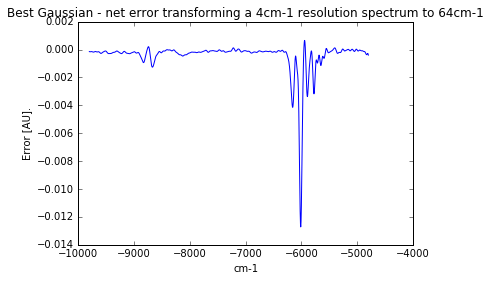

In [52]:
errBestGaussian = np.subtract(spectrum_res_64,np.convolve(spectrum_res_4,makeGaussianFilter(2,test_range[bestGaussianIdx]),'same'))
plt.plot(wn[400:-400],errBestGaussian[400:-400])
plt.title('Best Gaussian - net error transforming a 4cm-1 resolution spectrum to 64cm-1')
plt.ylabel('Error [AU].')
plt.xlabel("cm-1")
plt.show()